In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sicapv2/SICAPv2/SICAPv2/readme.txt
/kaggle/input/sicapv2/SICAPv2/SICAPv2/wsi_labels.xlsx
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/16B0006669_Block_Region_24_6_2_xini_14275_yini_13598.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/18B0005230E_Block_Region_5_11_23_xini_38257_yini_96363.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/18B0006621D_Block_Region_2_1_13_xini_21582_yini_66086.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/18B0006177A_Block_Region_2_6_19_xini_51693_yini_147491.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/16B0022612_Block_Region_1_20_12_xini_15667_yini_92428.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/17B0035220_Block_Region_5_22_18_xini_39584_yini_76503.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/16B0022615_Block_Region_4_19_41_xini_44968_yini_22920.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/17B0034247_Block_Region_2_21_7_xini_39052_yini_24363.jpg
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images/18B0005478I_Block_Region_2_1

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

# Base directory where the dataset is mounted
base_dir = "/kaggle/input/sicapv2"

# Check directory structure
for root, dirs, files in os.walk(base_dir):
    print(f"{root} -> {len(files)} files")


/kaggle/input/sicapv2 -> 0 files
/kaggle/input/sicapv2/SICAPv2 -> 0 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2 -> 2 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/images -> 18783 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/partition -> 0 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/partition/Validation -> 0 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/partition/Validation/Val3 -> 4 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/partition/Validation/Val4 -> 4 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/partition/Validation/Val2 -> 4 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/partition/Validation/Val1 -> 4 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/partition/Test -> 4 files
/kaggle/input/sicapv2/SICAPv2/SICAPv2/masks -> 18783 files


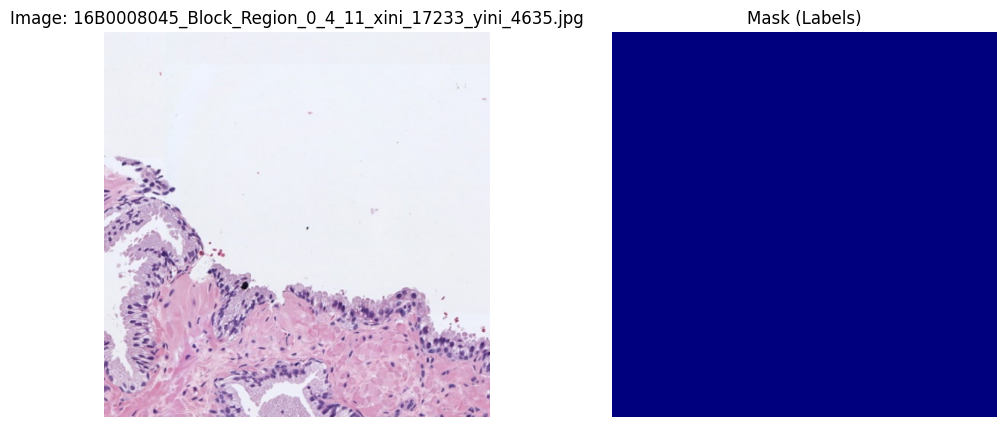

In [3]:
import random
from glob import glob

# Paths
image_dir = os.path.join(base_dir, "SICAPv2", "SICAPv2", "images")
mask_dir = os.path.join(base_dir, "SICAPv2", "SICAPv2", "masks")

# Pick a random image file
image_paths = glob(os.path.join(image_dir, "*.jpg"))
sample_image_path = random.choice(image_paths)
filename = os.path.basename(sample_image_path)
sample_mask_path = os.path.join(mask_dir, filename)

# Load image and mask
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE)

# Display
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Image: {filename}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='jet')
plt.title("Mask (Labels)")
plt.axis('off')
plt.show()


In [4]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

# Convert class labels to integers
label_to_idx = {"NC": 0, "GG3": 1, "GG4": 2, "GG5": 3}

# Define image transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Custom Dataset class
class PatchDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "path"]
        label_str = self.df.loc[idx, "label"]
        label = label_to_idx[label_str]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
import pandas as pd
from glob import glob
import os

# Load slide-level labels
xlsx_path = "/kaggle/input/sicapv2/SICAPv2/SICAPv2/wsi_labels.xlsx"
labels_df = pd.read_excel(xlsx_path)

def gleason_to_gg(primary, secondary):
    total = primary + secondary
    if total == 7 and primary == 4:
        return "GG3"
    elif total == 8:
        return "GG4"
    elif total >= 9:
        return "GG5"
    else:
        return "NC"

labels_df["GG"] = labels_df.apply(lambda row: gleason_to_gg(row["Gleason_primary"], row["Gleason_secondary"]), axis=1)
slideid_to_gg = dict(zip(labels_df["slide_id"].astype(str), labels_df["GG"]))

# Image patch folder
patch_dir = "/kaggle/input/sicapv2/SICAPv2/SICAPv2/images"
patch_paths = glob(os.path.join(patch_dir, "*.jpg"))  # .jpg format

# Map patches to GG labels via slide_id
patch_data = []
for path in patch_paths:
    filename = os.path.basename(path)
    slide_id = filename.split("_")[0]
    if slide_id in slideid_to_gg:
        label = slideid_to_gg[slide_id]
        patch_data.append((path, label))

# Final dataframe
patch_df = pd.DataFrame(patch_data, columns=["path", "label"])

# Confirm
print("patch_df ready ✅")
print(patch_df.head())
print(patch_df["label"].value_counts())


patch_df ready ✅
                                                path label
0  /kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...   GG5
1  /kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...    NC
2  /kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...   GG3
3  /kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...   GG5
4  /kaggle/input/sicapv2/SICAPv2/SICAPv2/images/1...    NC
label
NC     7995
GG5    5654
GG3    3082
GG4    2052
Name: count, dtype: int64


In [6]:
# Repeat split code
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    patch_df,
    test_size=0.2,
    stratify=patch_df["label"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=42
)

print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")


Train: 15026
Validation: 1878
Test: 1879


In [7]:
from torch.utils.data import DataLoader

# Reuse your PatchDataset and transforms
# If you haven't defined them yet in the current session, let me know

# Create dataset objects
train_dataset = PatchDataset(train_df, transform=train_transform)
val_dataset = PatchDataset(val_df, transform=val_transform)
test_dataset = PatchDataset(test_df, transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Confirm one batch works
sample_images, sample_labels = next(iter(train_loader))
print("Sample batch shape:", sample_images.shape)
print("Sample labels:", sample_labels[:10])


Sample batch shape: torch.Size([32, 3, 224, 224])
Sample labels: tensor([0, 0, 0, 2, 0, 2, 3, 1, 0, 0])


In [8]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load ResNet50 without pretrained weights
model = models.resnet50(weights=None)

# Modify final classifier layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)

# Send to GPU
model = model.to(device)


Using device: cuda


In [ ]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Optional: Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [10]:
import torch.optim as optim
import torch.nn as nn

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Optional: Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [11]:
import os
import time
import copy
import torch
import torch.nn as nn

num_epochs = 10
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

os.makedirs("checkpoints", exist_ok=True)  # Create folder for checkpoints

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            loader = train_loader
        else:
            model.eval()
            loader = val_loader

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = running_corrects.double() / len(loader.dataset)

        print(f"{phase.title()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

        if phase == 'train':
            train_acc_history.append(epoch_acc.item())
            train_loss_history.append(epoch_loss)
            scheduler.step()
        else:
            val_acc_history.append(epoch_acc.item())
            val_loss_history.append(epoch_loss)

            # Save best model
            if epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), "best_resnet_model.pth")
                print("✅ Best model updated.")

    # Save checkpoint every epoch
    checkpoint_path = f"checkpoints/resnet_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"💾 Checkpoint saved: {checkpoint_path}")

print("\n✅ Training complete")
print(f"Best validation accuracy: {best_val_acc:.4f}")

# Load best model weights
model.load_state_dict(best_model_wts)



Epoch 1/10
------------------------------
Train Loss: 1.1651 | Acc: 0.4981
Val Loss: 1.0792 | Acc: 0.5282
✅ Best model updated.
💾 Checkpoint saved: checkpoints/resnet_epoch_1.pth

Epoch 2/10
------------------------------
Train Loss: 1.0450 | Acc: 0.5606
Val Loss: 1.0432 | Acc: 0.5469
✅ Best model updated.
💾 Checkpoint saved: checkpoints/resnet_epoch_2.pth

Epoch 3/10
------------------------------
Train Loss: 0.9722 | Acc: 0.5976
Val Loss: 1.0158 | Acc: 0.5809
✅ Best model updated.
💾 Checkpoint saved: checkpoints/resnet_epoch_3.pth

Epoch 4/10
------------------------------
Train Loss: 0.8990 | Acc: 0.6276
Val Loss: 0.7970 | Acc: 0.6864
✅ Best model updated.
💾 Checkpoint saved: checkpoints/resnet_epoch_4.pth

Epoch 5/10
------------------------------
Train Loss: 0.8349 | Acc: 0.6540
Val Loss: 1.4495 | Acc: 0.5985
💾 Checkpoint saved: checkpoints/resnet_epoch_5.pth

Epoch 6/10
------------------------------
Train Loss: 0.7399 | Acc: 0.6927
Val Loss: 0.7455 | Acc: 0.6981
✅ Best model up

<All keys matched successfully>

In [12]:
# Load best model
model.load_state_dict(torch.load("best_resnet_model.pth"))


<All keys matched successfully>


📊 Classification Report:

              precision    recall  f1-score   support

          NC       0.87      0.86      0.87       800
         GG3       0.68      0.79      0.73       308
         GG4       0.72      0.63      0.67       205
         GG5       0.80      0.79      0.80       566

    accuracy                           0.80      1879
   macro avg       0.77      0.77      0.77      1879
weighted avg       0.80      0.80      0.80      1879



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


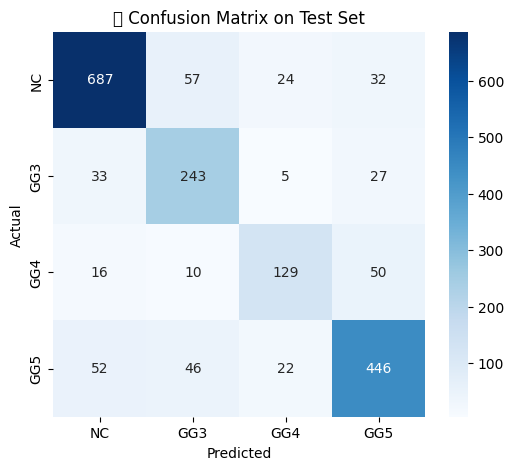

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load best model
model.load_state_dict(torch.load("best_resnet_model.pth"))
model.eval()

# Run inference on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
target_names = ['NC', 'GG3', 'GG4', 'GG5']
print("\n📊 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("🧪 Confusion Matrix on Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


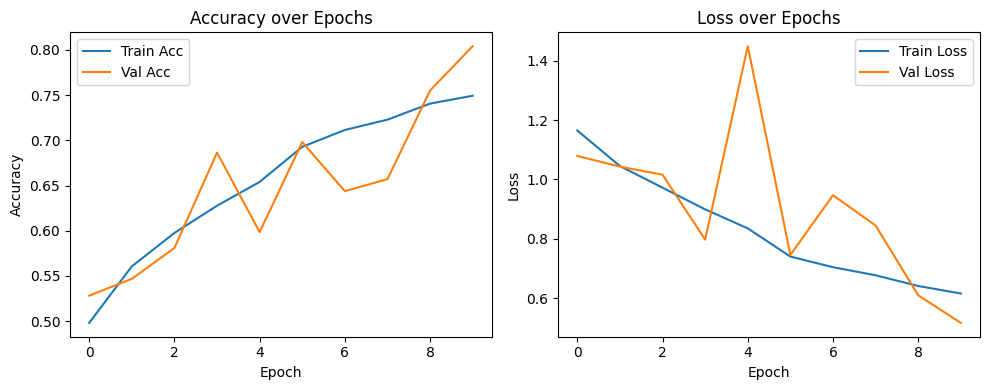

In [15]:
# Accuracy plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
# Save full model (structure + weights)
torch.save(model, "final_resnet_model.pth")


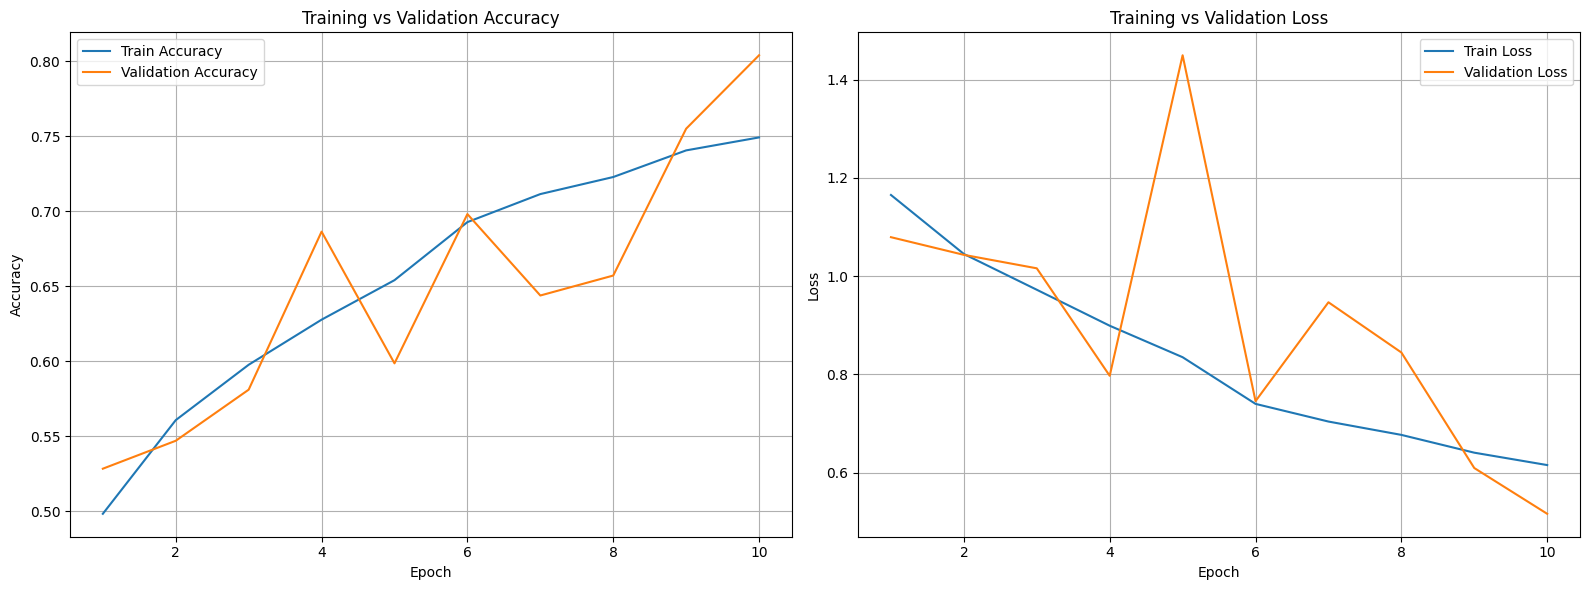

In [17]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_acc_history)+1))

plt.figure(figsize=(16, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_history, label="Train Accuracy")
plt.plot(epochs, val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.plot(epochs, val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [19]:
model.load_state_dict(torch.load("best_resnet_model.pth"))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
class_names = ['NC', 'GG3', 'GG4', 'GG5']


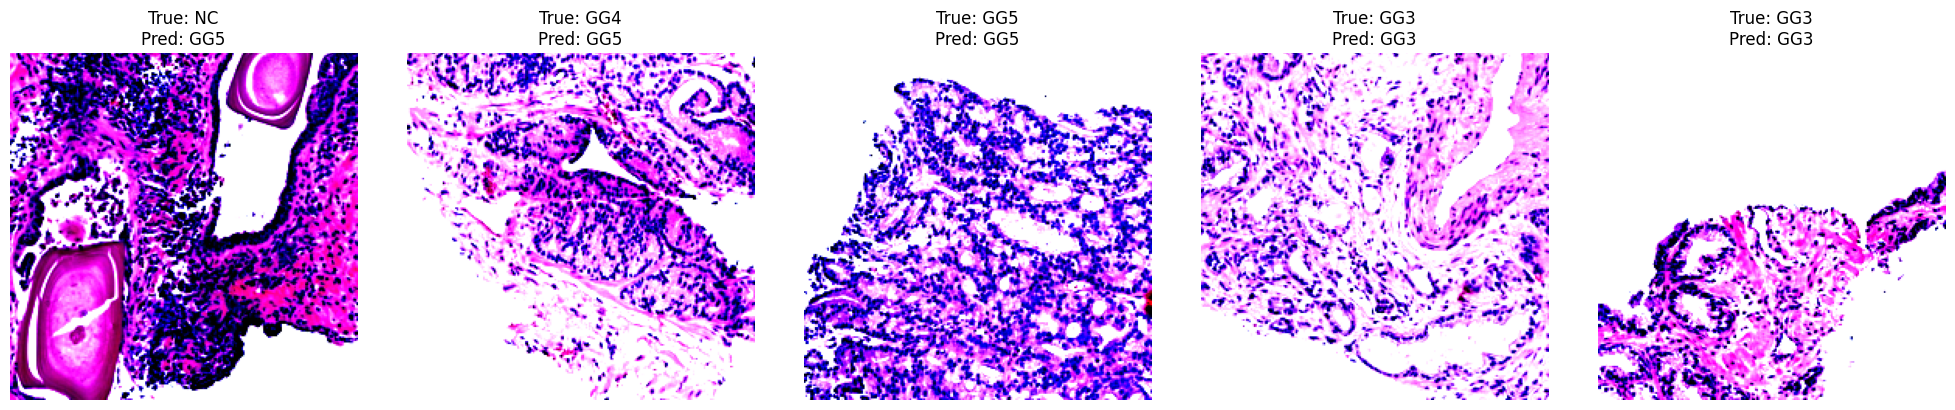

In [21]:
import random

# Pick 5 random test samples
indices = random.sample(range(len(test_dataset)), 5)

model.eval()
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for i, idx in enumerate(indices):
    image, true_label = test_dataset[idx]
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, pred_label = torch.max(output, 1)

    axs[i].imshow(image.permute(1, 2, 0).cpu())  # Convert tensor to image
    axs[i].axis('off')
    axs[i].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label.item()]}", fontsize=12)

plt.tight_layout()
plt.show()


In [22]:
model.load_state_dict(torch.load("best_resnet_model.pth"))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

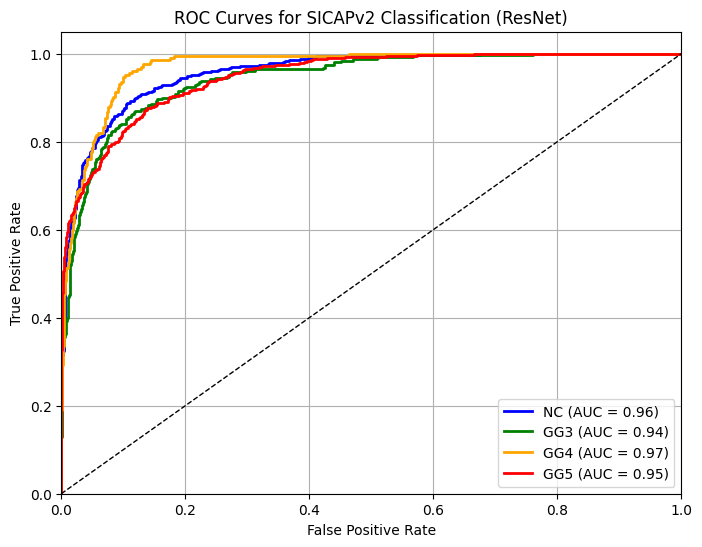

In [26]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Get raw model scores (not just predicted labels)
model.eval()
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

y_score = np.array(all_probs)
y_test_binarized = label_binarize(y_true, classes=[0, 1, 2, 3])  # NC, GG3, GG4, GG5

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'orange', 'red']
class_names = ['NC', 'GG3', 'GG4', 'GG5']

for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for SICAPv2 Classification (ResNet)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [27]:
model.load_state_dict(torch.load("best_resnet_model.pth"))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [29]:
import pandas as pd
import torch.nn.functional as F

# In case you haven't already
class_names = ['NC', 'GG3', 'GG4', 'GG5']

model.eval()
results = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        for j in range(inputs.size(0)):
            results.append({
                'true_label_index': labels[j].item(),
                'true_label_name': class_names[labels[j].item()],
                'pred_label_index': preds[j].item(),
                'pred_label_name': class_names[preds[j].item()],
                'confidence': probs[j][preds[j]].item()
            })

# Save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("test_predictions_resnet.csv", index=False)

print("✅ Test predictions saved to test_predictions_resnet.csv")


✅ Test predictions saved to test_predictions_resnet.csv


In [30]:
torch.save(model, "final_resnet_model.pth")
